In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
from sklearn.metrics import matthews_corrcoef as MCC
import seaborn as sns; sns.set()


from technicalSignals import momentum,SMA,inBBands


In [13]:
tickers=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX']
TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]
kind_of_dataset = 'AffectiveSpace'


In [14]:
class DatasetManager:
    def __init__(self):
        X_raw = None
        Y_raw = None
        Y = None
        X = None
        cum_ret = None
    
    def load_dataset(self, ticker, kind, technicalFeatures=False):
        types = {'Summary': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/',
            'AffectiveSpace': '/home/simone/Desktop/NLFF/AffectiveSpace/Aggregated_AffectSummary_dataset/',
            'Title': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentTitleAggregatedHourly/',
            'Senticnet':''}
        news =  pd.read_csv(types[kind]+ticker+'.csv')
        price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news = news.drop(['Unnamed: 0'], axis=1)
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        if(technicalFeatures):
            price['mom_30'] = momentum(price, 30)
            price['mom_50'] = momentum(price, 50)
            price['mom_100'] = momentum(price, 100)
            price['mom_150'] = momentum(price, 150)
            price['SMA_30'] = SMA(price, 30)
            price['SMA_50'] = SMA(price, 50)
            price['SMA_100'] = SMA(price, 100)
            price['SMA_150'] = SMA(price, 150)
            price['in_BBands'] = inBBands(price)

        #ALLIGNMENT
        initDate = max(news['DATE'][0], datetime(2017, 5, 22, 0, 0, 0))
        finalDate = min(news['DATE'][len(news)-1],datetime(2018, 6, 21, 0, 0, 0))
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        assert len(price) == len(news)
        # FEATURES
        sentiment = news.drop(['DATE'], axis=1)
        X = sentiment
        for window in [5,10,15,20,30,50]:
            temp = sentiment.rolling(window).mean()
            temp.columns = temp.columns +'_'+str(window)
            X = pd.concat([X, temp],axis=1)
        if(technicalFeatures):   
            technical_features = ['mom_30','mom_50','mom_100','mom_150','SMA_30','SMA_50','SMA_100','SMA_150','in_BBands']
            X = pd.concat([X, price[technical_features]],axis=1)

            
        #NORMALIZATION:
        min_max_scaler = preprocessing.MinMaxScaler()
        X = np.nan_to_num(np.asarray(X, dtype=float))
        X = np.asarray(min_max_scaler.fit_transform(X))
        self.X_raw = X
        self.Y_raw = price
        
    def get_dataset_for_trend(self, init, finish, perc_train = 0.7):
        y = list()
        x = list()
        dates = list()
        price = self.Y_raw
        for i in range(abs(init),len(price)-finish):
            cumulative_return =  (price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
            y.append(cumulative_return)
            dates.append(price.iloc[i]['DATE'])
            x.append(self.X_raw[i])

        y = np.array(y)
        x = np.array(x)
        self.X = x
        nt=math.ceil(len(x)*perc_train)
        y_tv = y[:nt]
        # Choose thresholds based on train
        sort = sorted(y_tv)
        samples_per_class = math.floor(len(y_tv)/3)
        low_threshold = sort[samples_per_class]
        up_threshold = sort[2*samples_per_class]
        y = [1 if s > up_threshold else -1 if s < low_threshold else 0 for s in y]
        
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        dates_test = dates[nt:]
        return (x_tv,y_tv),(x_test,y_test),dates_test


In [15]:
def cv(x_tv,y_tv):
    best_mcc = -float(np.inf)
    best_c = 0
    best_g = 0
    for c in np.logspace(-2,5,15):
        for g in np.logspace(-5,2,15):
            print('.', end='')
            trainpoint=math.floor(len(x_tv)*0.50)
            dimval=math.floor(trainpoint*0.25)
            endval=trainpoint+dimval
            #Cross validation
            cvMCC = 0
            for i in range(0,4):
                x_train=x_tv[0:trainpoint]
                y_train=y_tv[0:trainpoint]
                x_val=x_tv[trainpoint:endval]
                y_val=y_tv[trainpoint:endval]
                trainpoint=trainpoint+dimval
                endval=endval+dimval
                svm_model = svm.SVC(kernel='rbf', C=c, gamma=g)
                svm_model.fit(x_train,y_train)
                y_pred = svm_model.predict(x_val)
                mcc = MCC(y_val, y_pred)
                cvMCC += mcc/4

            if(cvMCC > best_mcc):
                best_mcc = cvMCC
                best_c = c
                best_g = g
        
    return (best_c, best_g)

def loss_exploration(x_tv,y_tv, x_test, y_test):
    ACCs = np.ones([15,15])*-1
    MCCs = np.ones([15,15])*-1
    cSpace = np.logspace(-2,5,15)
    gSpace = np.logspace(-5,2,15)
    for c in range(0,15):
        for g in range(0,15):
            print('.', end='')
            svm_model = svm.SVC(kernel='rbf', C=cSpace[c], gamma=gSpace[g])
            svm_model.fit(x_tv,y_tv)
            acc = svm_model.score(x_test,y_test)
            y_pred = svm_model.predict(x_test)
            mcc = MCC(y_test, y_pred)
            ACCs[c][g] = acc
            MCCs[c][g] = mcc
    fig,(ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
    fig.suptitle('y(t) = p(t'+'{0:+}'.format(finish)+') -  p(t '+'{0:+}'.format(init)+' )')
    ax1.set_title('MCC AffectSpace')
    sns_plot = sns.heatmap(MCCs, ax=ax1, vmin=-0.2, vmax=0.7, annot=True, fmt=".2f",cmap='coolwarm')
    ax2.set_title('Acc AffectSpace')
    sns_plot = sns.heatmap(ACCs, ax=ax2, vmin=0, vmax=1, annot=True, fmt=".2f")
    plt.savefig('AffectSpaceSumWithTechnicalIndicators/threeClasses-KSVM/AffSpace3Classes_Trend_('+str(init)+','+str(finish)+').jpg')

    




==================== AAPL ==================== 



trend:  -48   0
...........

/home/simone/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


......................................................................................................................................................................................................................trend:  -35   0
.................................................................................................................................................................................................................................trend:  -28   0
.................................................................................................................................................................................................................................trend:  -7   0
.................................................................................................................................................................................................................................trend:  -1   0
.................................................

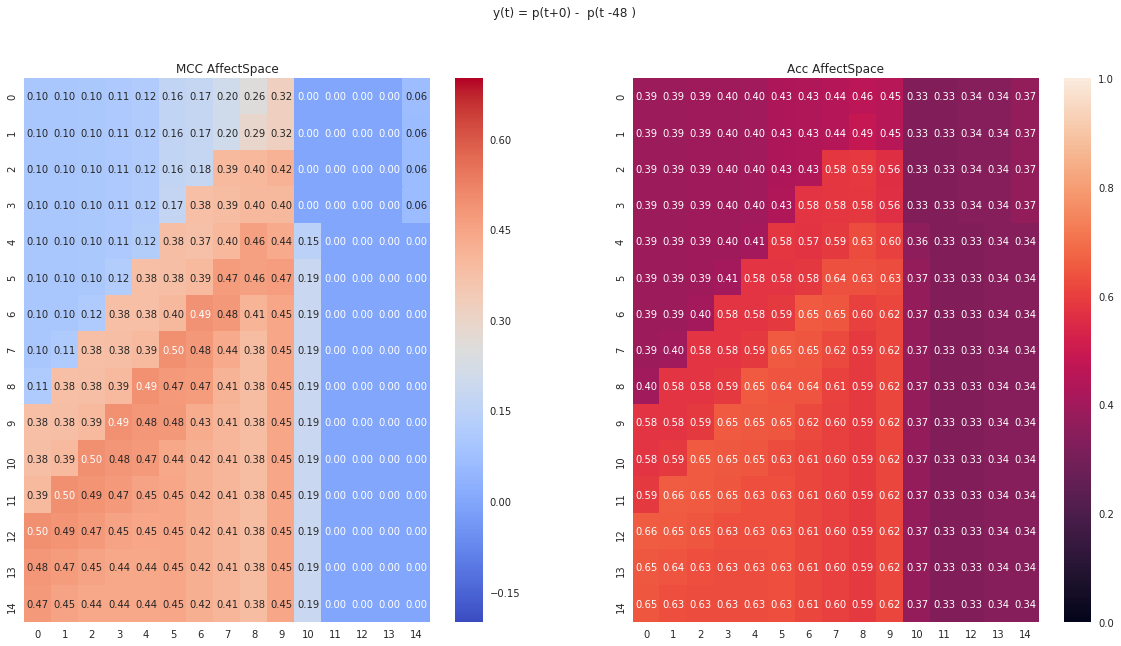

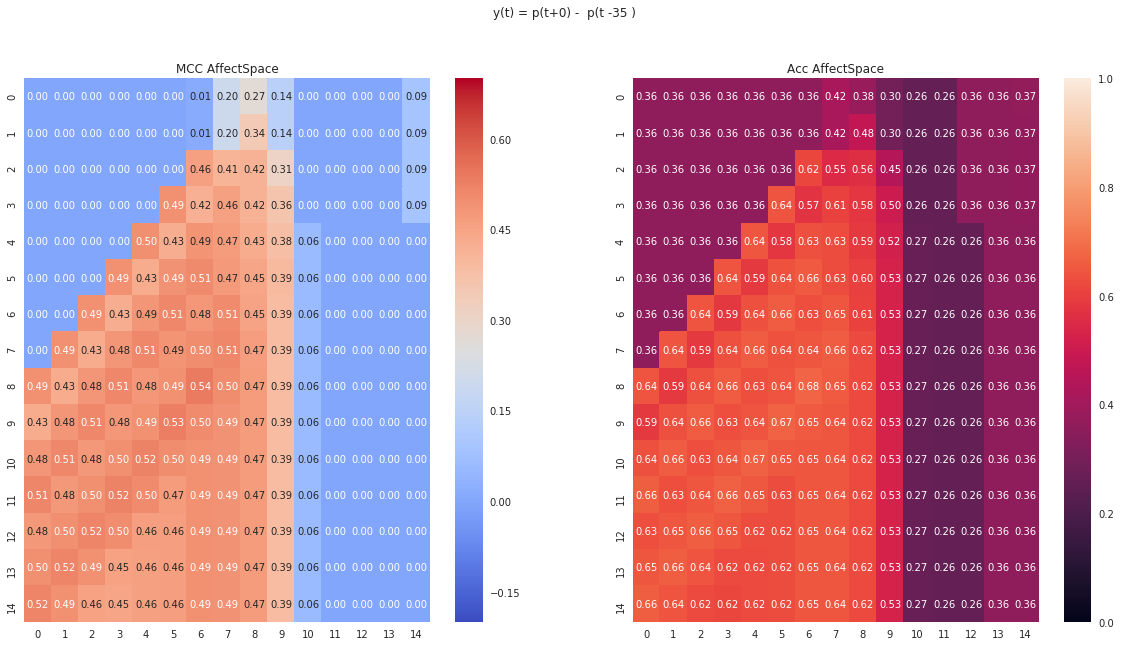

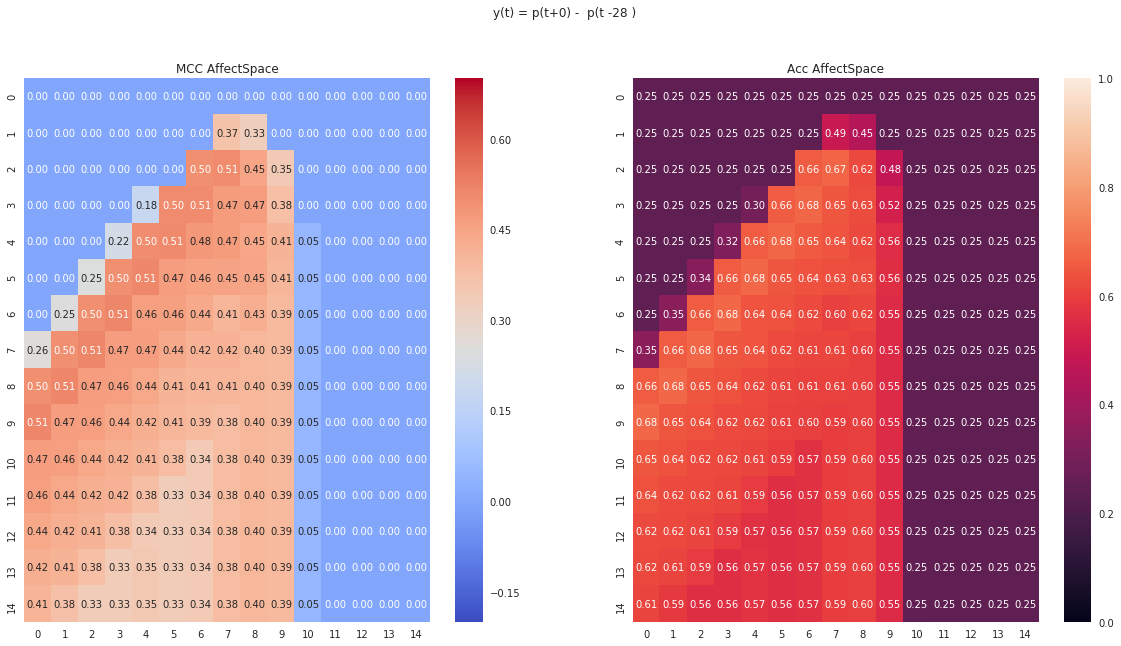

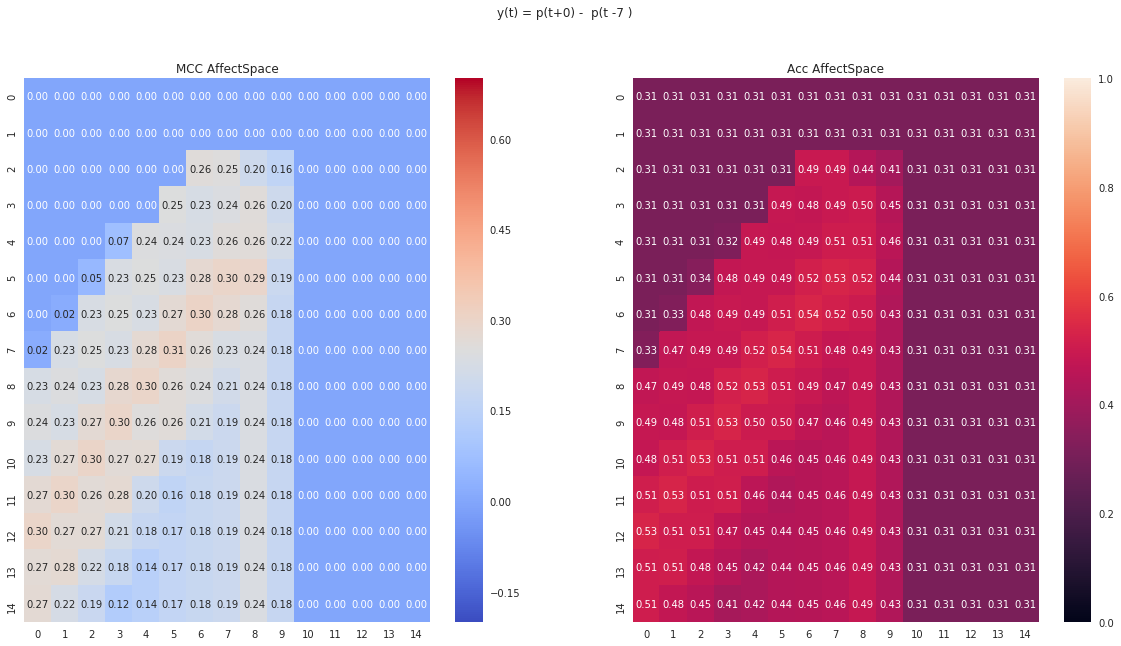

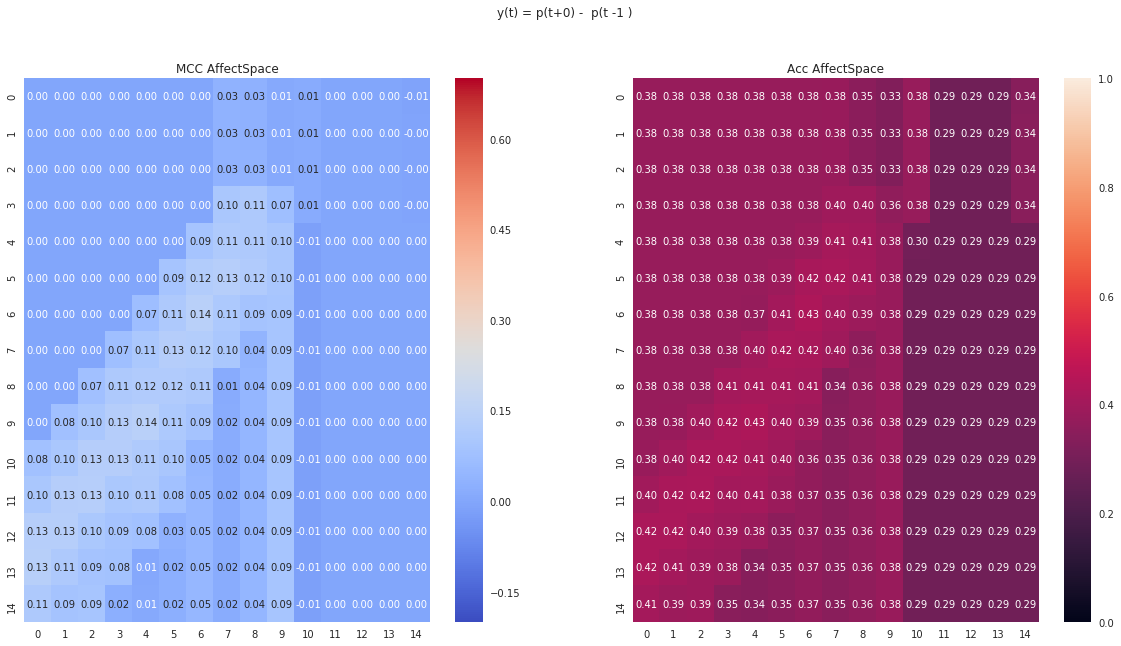

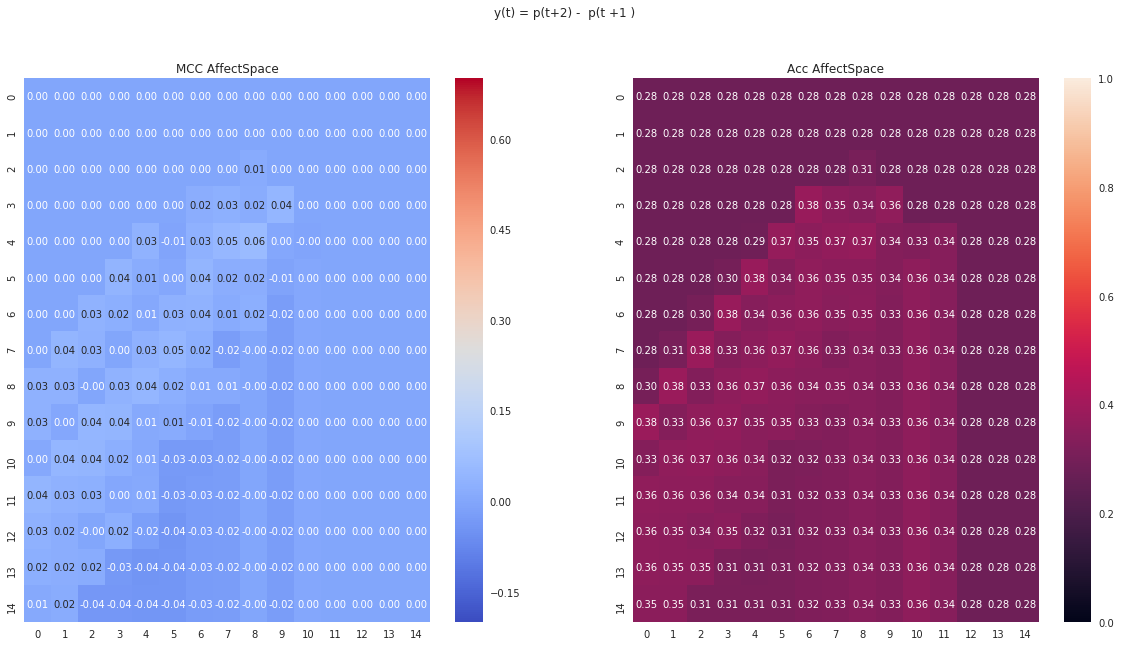

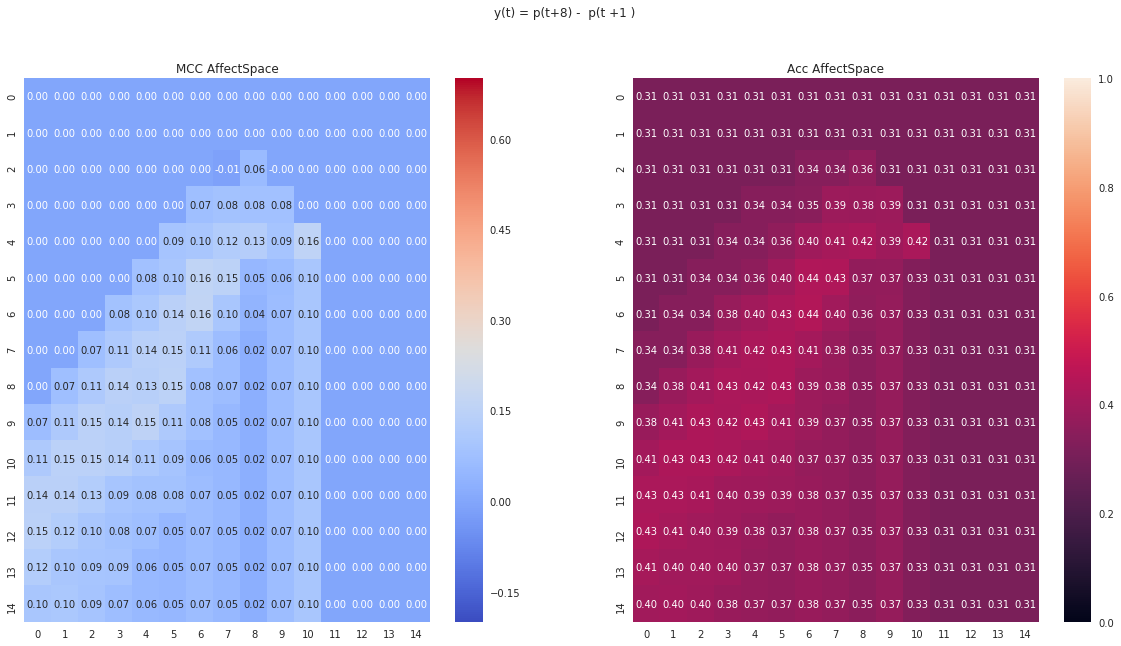

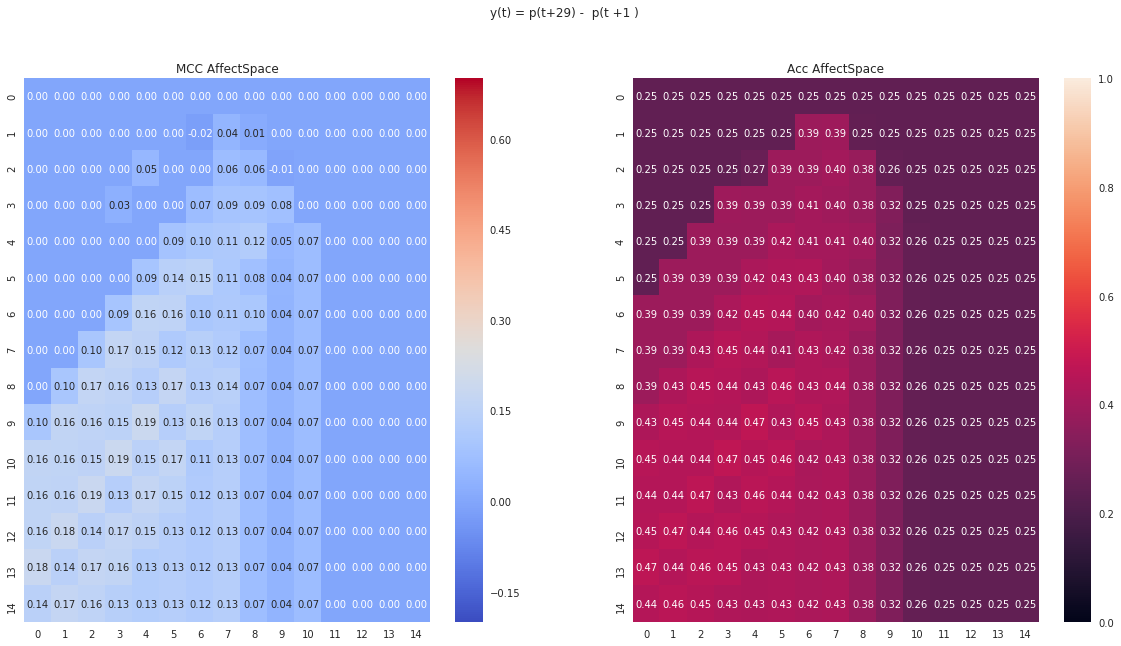

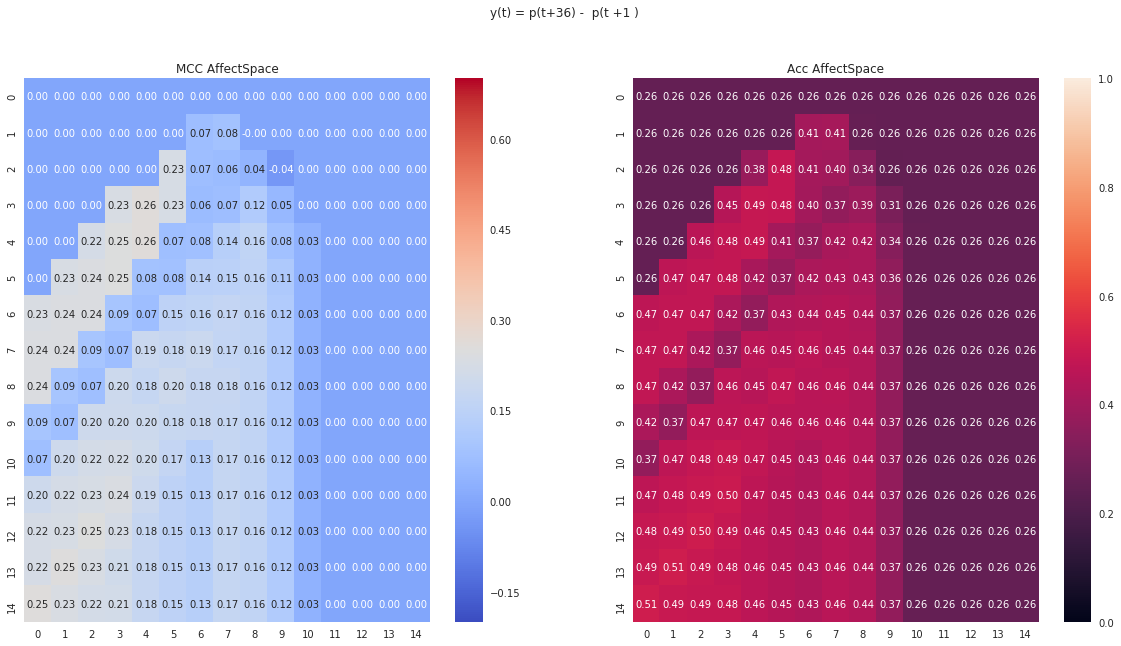

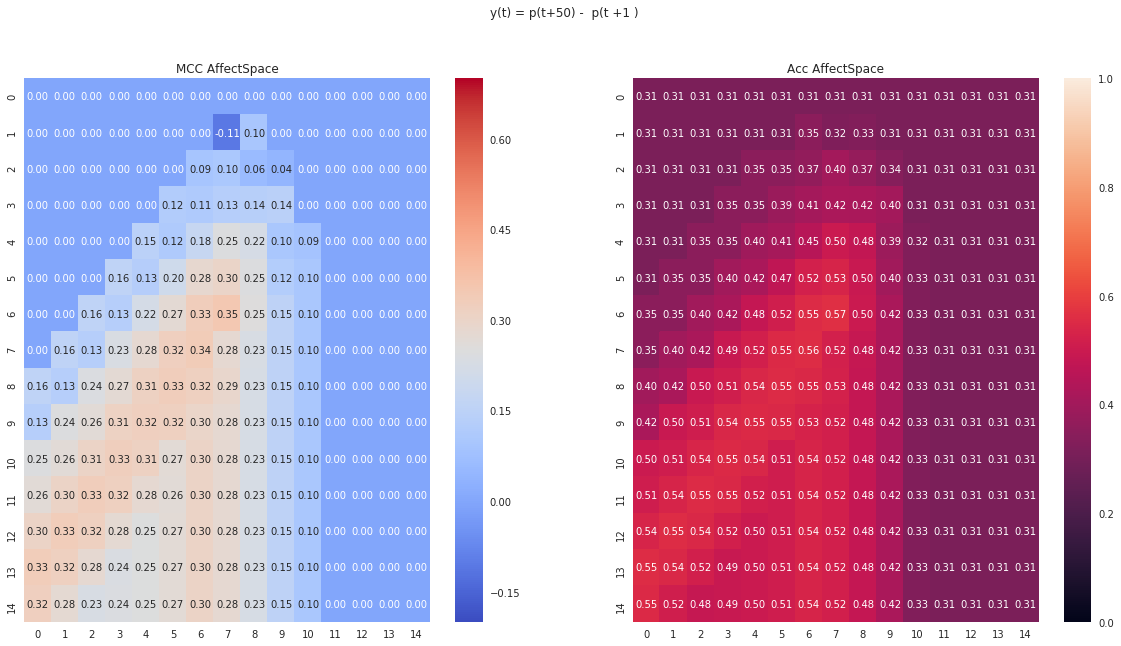

In [5]:
# 1) discovery of the loss shape
conf_matr_avg = np.zeros([2,2])
for ticker in tickers:
    print('\n\n\n==================== '+str(ticker)+' ==================== \n\n\n')
    MCCs = []
    ACCs = []
    ds = DatasetManager()
    ds.load_dataset(ticker = ticker, kind = kind_of_dataset,technicalFeatures=True)

    for (init, finish) in TREND_WINDOWs:
        print('trend: ',init,' ',finish)
        #cv(x_tv,y_tv)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        loss_exploration(x_tv,y_tv, x_test, y_test)
        
        
        
    





==================== AAPL ==================== 



trend:  -48   0
.

/home/simone/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


................................................................................................................................................................................................................................Best C:  100.0  best gamma:  0.0031622776601683794

tn, fp, fn, tp:  [  0   0 186   0   0 182   0   0 188]
trend:  -35   0
.................................................................................................................................................................................................................................Best C:  100.0  best gamma:  0.00031622776601683794

tn, fp, fn, tp:  [  0   0 212   0   0 146   0   0 202]
trend:  -28   0
.................................................................................................................................................................................................................................Best C:  1.0  best gamma:  0.03162277660168379

tn, fp, fn, tp:  [  0 219   0  

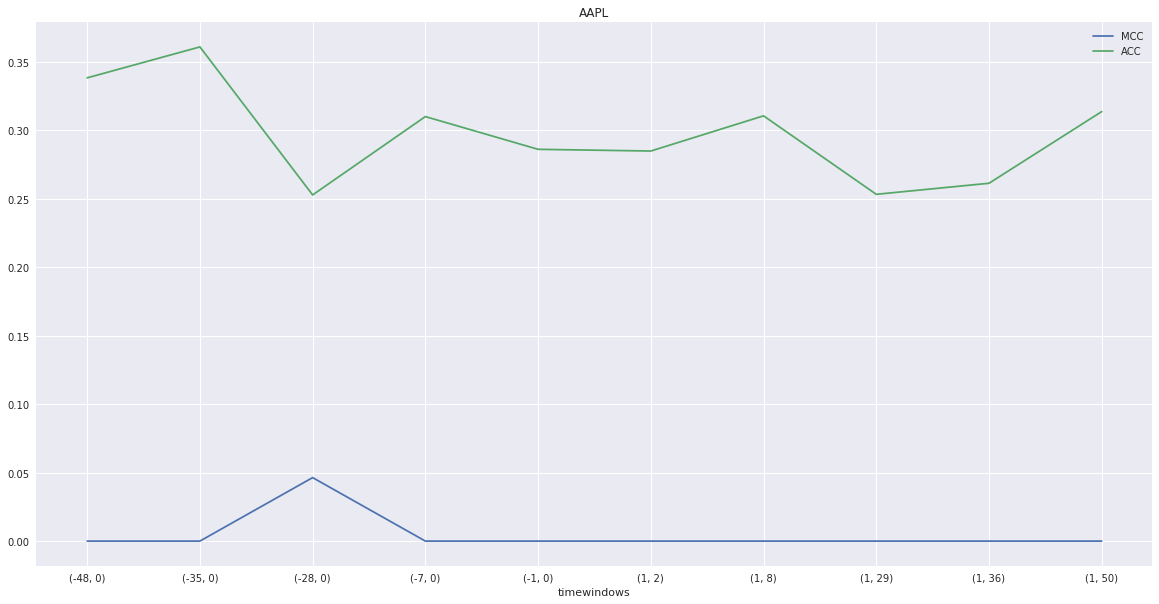




==================== AMZN ==================== 



trend:  -48   0
.................................................................................................................................................................................................................................Best C:  1000.0  best gamma:  0.00031622776601683794

tn, fp, fn, tp:  [  0   0 153   0   0 197   0   0 206]
trend:  -35   0
.................................................................................................................................................................................................................................Best C:  10000.0  best gamma:  1e-05

tn, fp, fn, tp:  [  0   0 158   0   0 189   0   0 213]
trend:  -28   0
.................................................................................................................................................................................................................................Best C:  3.1622776601

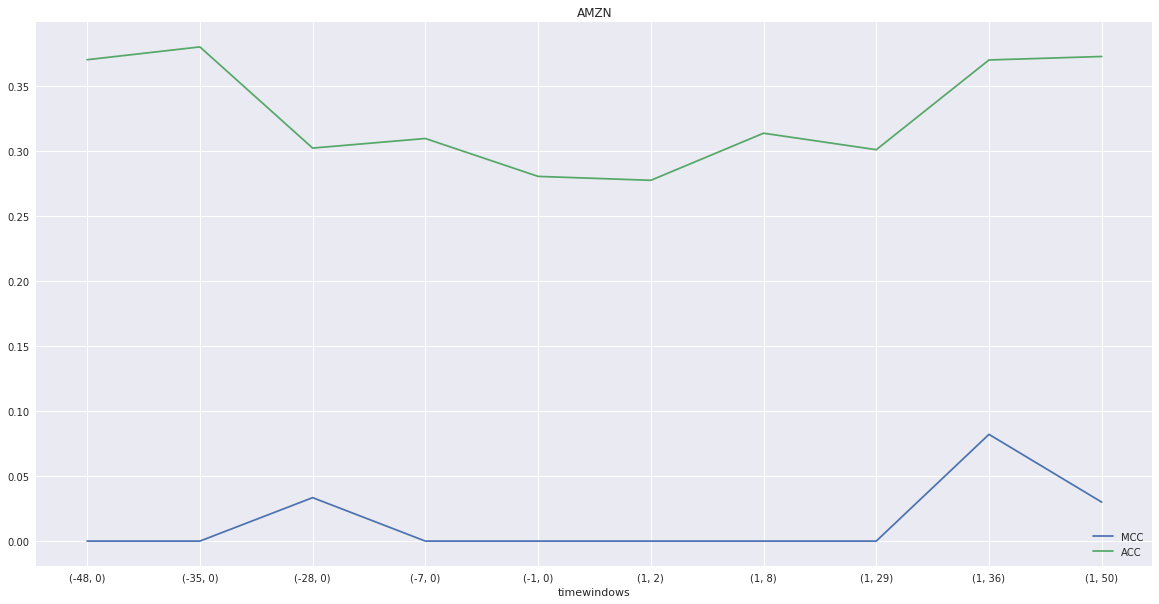




==================== GOOGL ==================== 



trend:  -48   0
.................................................................................................................................................................................................................................Best C:  3.1622776601683795  best gamma:  0.03162277660168379

tn, fp, fn, tp:  [224   0   0 110   0   0 221   0   1]
trend:  -35   0
.................................................................................................................................................................................................................................Best C:  3.1622776601683795  best gamma:  0.03162277660168379

tn, fp, fn, tp:  [  0 237   0   0  90   0   0 231   2]
trend:  -28   0
...................................................................................................................................................................................................................

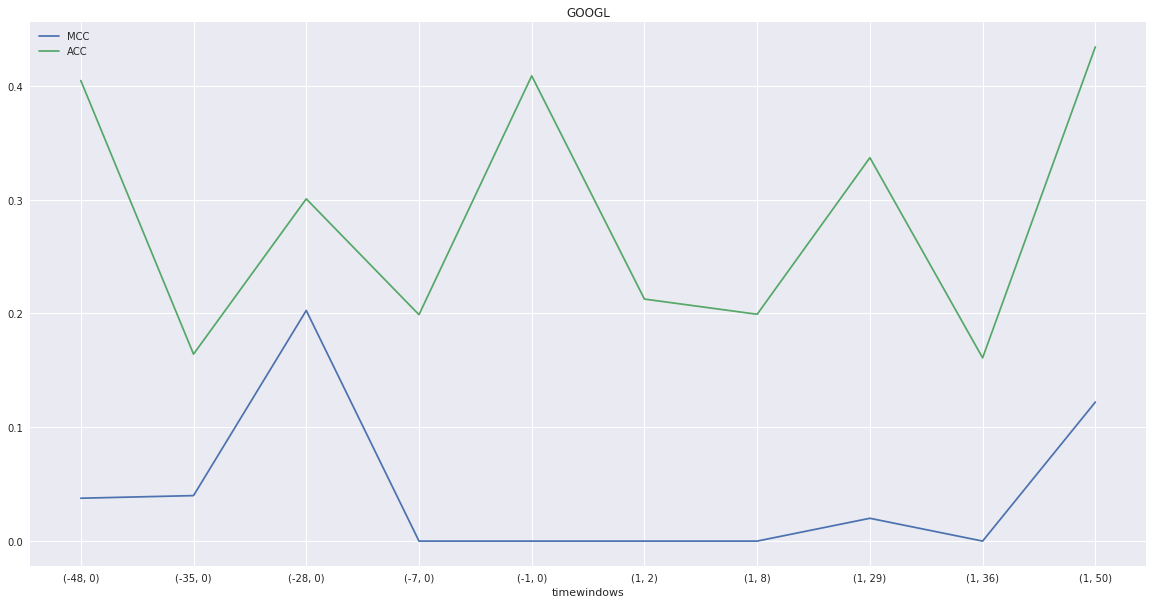




==================== MSFT ==================== 



trend:  -48   0
.................................................................................................................................................................................................................................Best C:  3162.2776601683795  best gamma:  0.0001

tn, fp, fn, tp:  [  0   0 199   0   0 192   0   0 165]
trend:  -35   0
.................................................................................................................................................................................................................................Best C:  316.22776601683796  best gamma:  0.001

tn, fp, fn, tp:  [  0   0 224   0   0 144   0   0 192]
trend:  -28   0
.................................................................................................................................................................................................................................Best C:  3.162

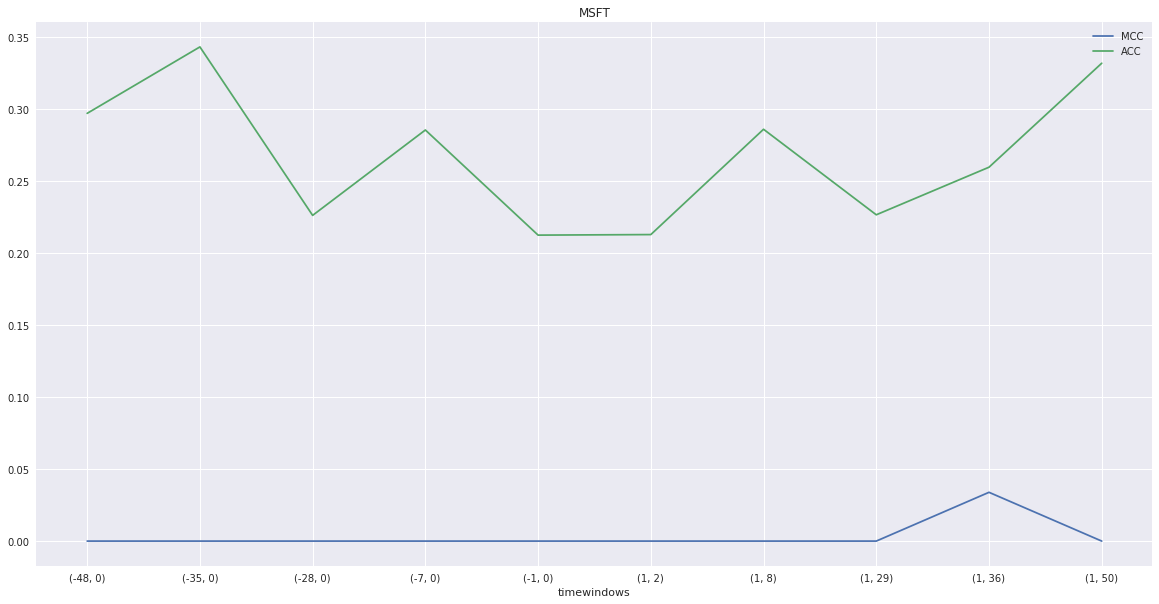




==================== FB ==================== 



trend:  -48   0
.................................................................................................................................................................................................................................Best C:  1000.0  best gamma:  0.0001

tn, fp, fn, tp:  [  0   0 136   0   0 157   0   0 263]
trend:  -35   0
.................................................................................................................................................................................................................................Best C:  3.1622776601683795  best gamma:  0.1

tn, fp, fn, tp:  [  0 172   0   0 135   0   0 252   1]
trend:  -28   0
.................................................................................................................................................................................................................................Best C:  100.0  best gamma:  0

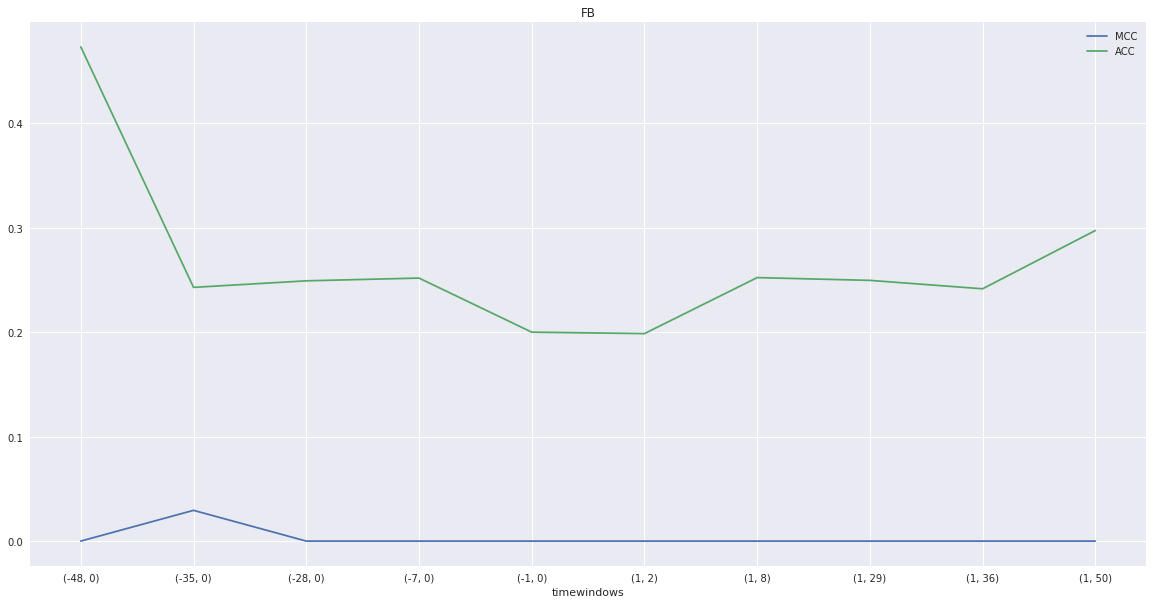




==================== INTC ==================== 



trend:  -48   0
.................................................................................................................................................................................................................................Best C:  100.0  best gamma:  0.00031622776601683794

tn, fp, fn, tp:  [  0 154   0   0 216   0   0 186   0]
trend:  -35   0
.................................................................................................................................................................................................................................Best C:  100.0  best gamma:  0.00031622776601683794

tn, fp, fn, tp:  [  0 165   0   0 175   0   0 220   0]
trend:  -28   0
.................................................................................................................................................................................................................................Best C:

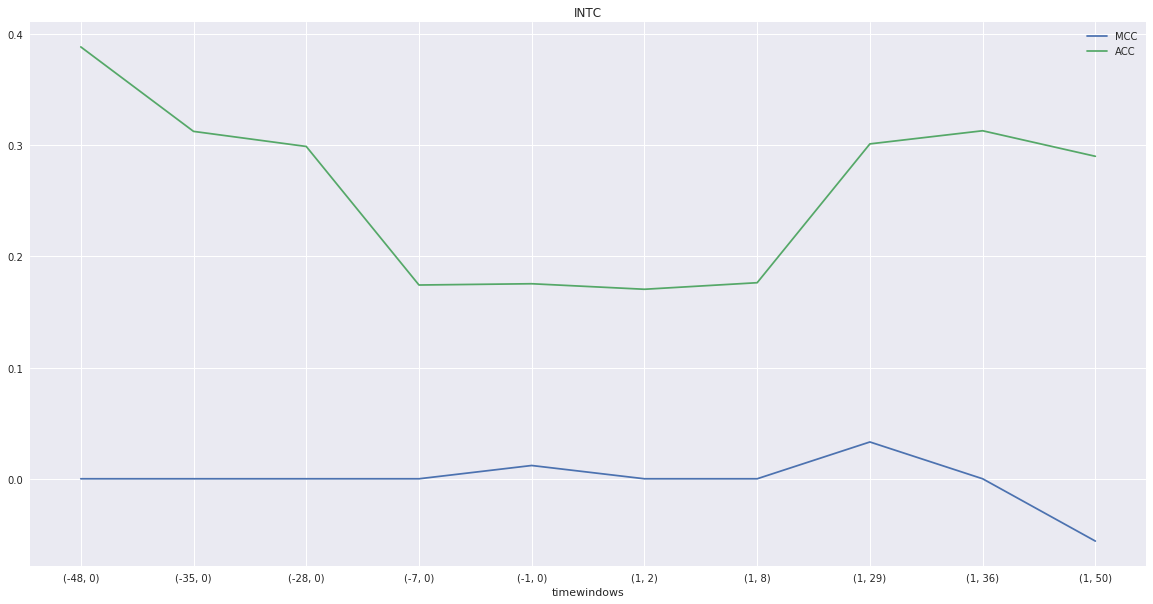




==================== CSCO ==================== 



trend:  -48   0
.................................................................................................................................................................................................................................Best C:  100.0  best gamma:  0.0001

tn, fp, fn, tp:  [  0   0 256   0   0 139   0   0 160]
trend:  -35   0
.................................................................................................................................................................................................................................Best C:  10.0  best gamma:  0.01

tn, fp, fn, tp:  [  0 248   0   0 128   0   0 183   0]
trend:  -28   0
.................................................................................................................................................................................................................................Best C:  31.622776601683793  best gamma:  

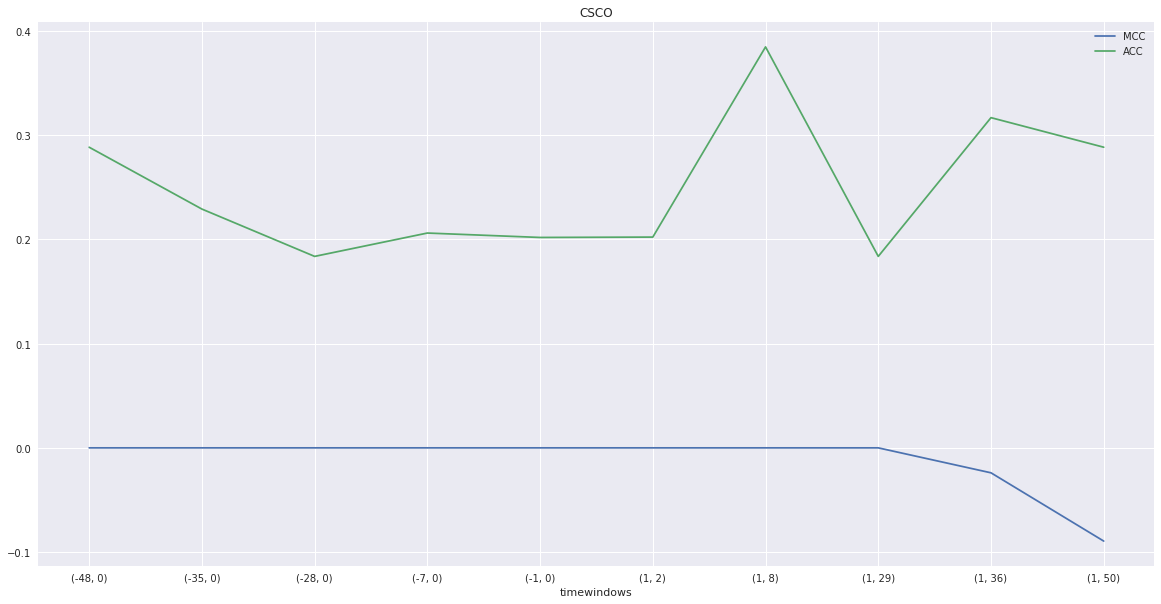




==================== CMCSA ==================== 



trend:  -48   0
.................................................................................................................................................................................................................................Best C:  3.1622776601683795  best gamma:  0.01

tn, fp, fn, tp:  [293   0   0 115   0   0 148   0   0]
trend:  -35   0
.................................................................................................................................................................................................................................Best C:  31.622776601683793  best gamma:  0.03162277660168379

tn, fp, fn, tp:  [  0   0 245   0   0 144   0   0 171]
trend:  -28   0
.................................................................................................................................................................................................................................B

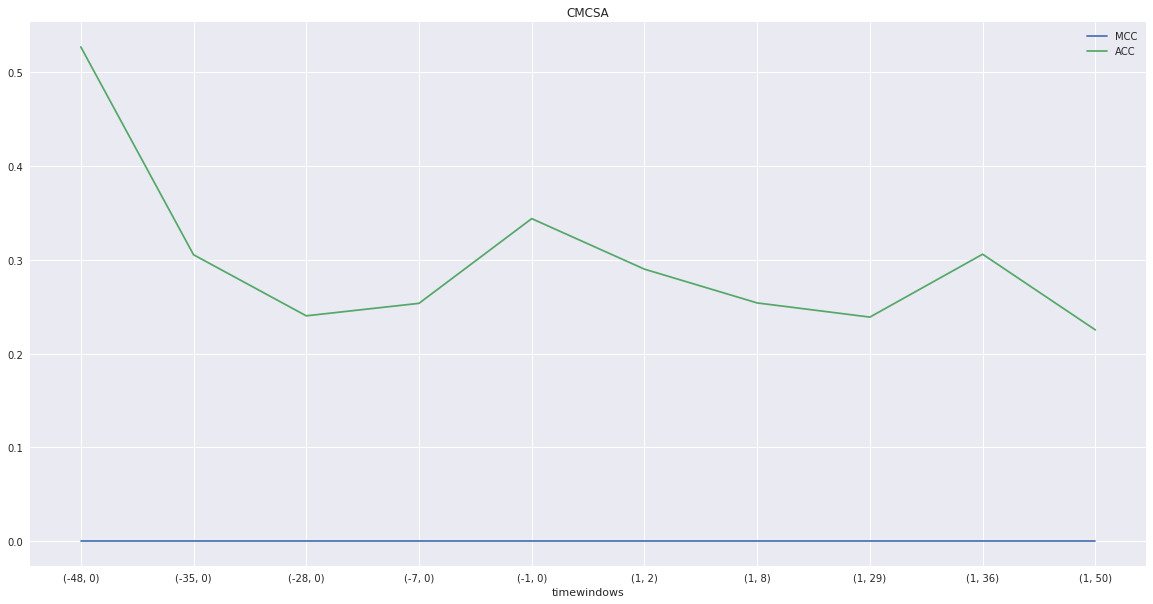




==================== NVDA ==================== 



trend:  -48   0
.................................................................................................................................................................................................................................Best C:  100000.0  best gamma:  1e-05

tn, fp, fn, tp:  [  0   0 283   0   0 138   0   0 135]
trend:  -35   0
.................................................................................................................................................................................................................................Best C:  3162.2776601683795  best gamma:  3.1622776601683795e-05

tn, fp, fn, tp:  [  0   0 282   0   0 137   0   0 141]
trend:  -28   0
.................................................................................................................................................................................................................................Best C: 

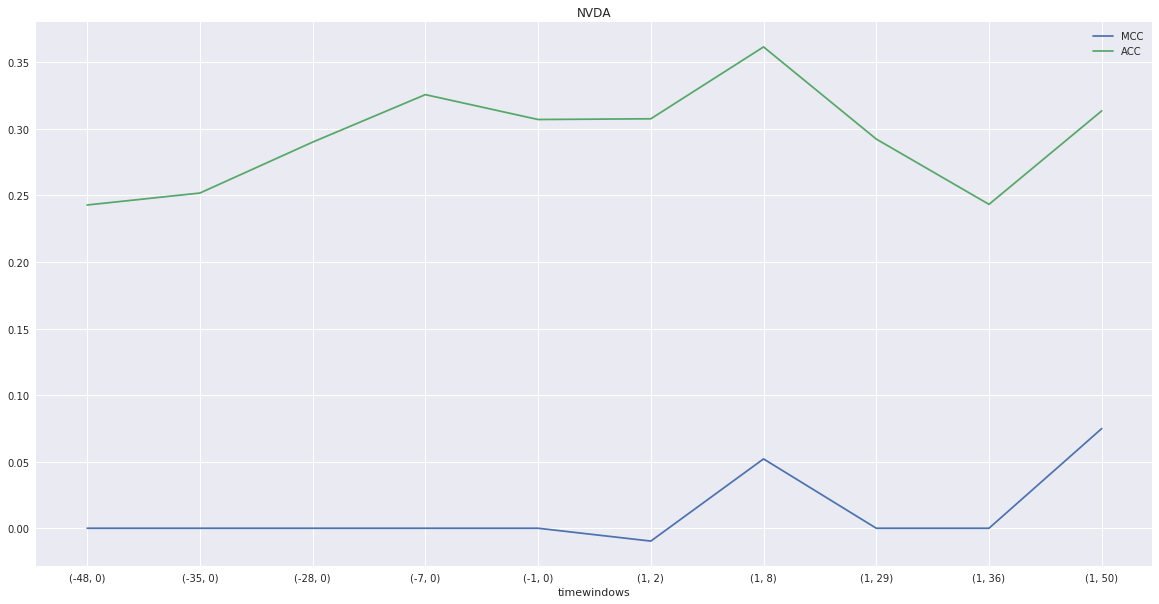




==================== NFLX ==================== 



trend:  -48   0
.................................................................................................................................................................................................................................Best C:  1.0  best gamma:  0.1

tn, fp, fn, tp:  [137   0   0 134  11   0 245  27   2]
trend:  -35   0
.................................................................................................................................................................................................................................Best C:  10000.0  best gamma:  0.001

tn, fp, fn, tp:  [  0   0 137   0   0 136   0   0 287]
trend:  -28   0
.................................................................................................................................................................................................................................Best C:  1000.0  best gamma:  0.00031622776

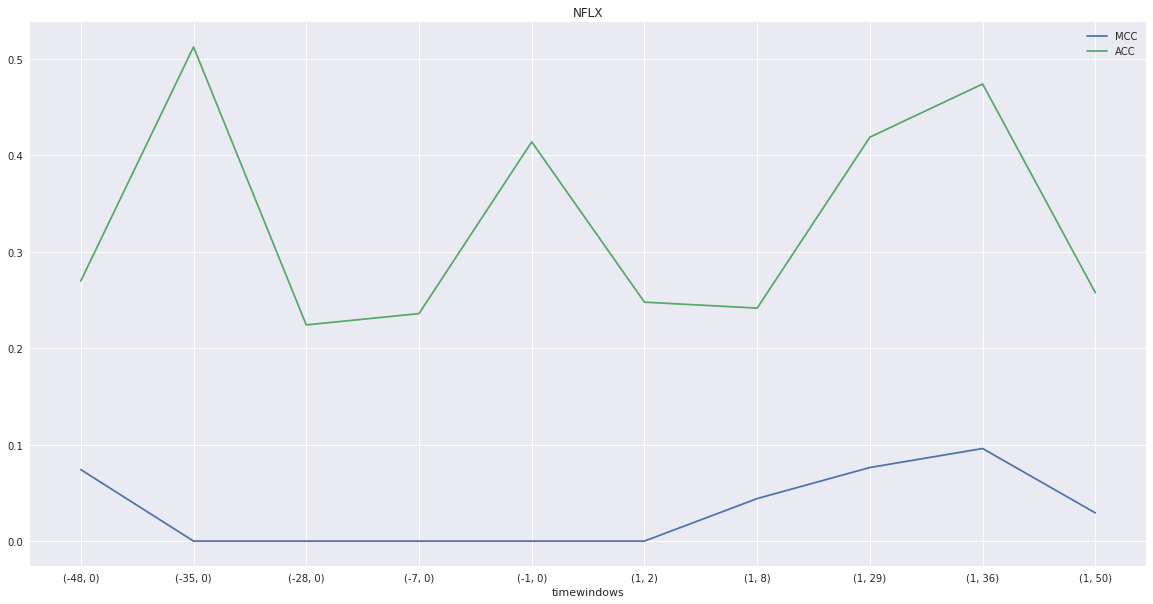

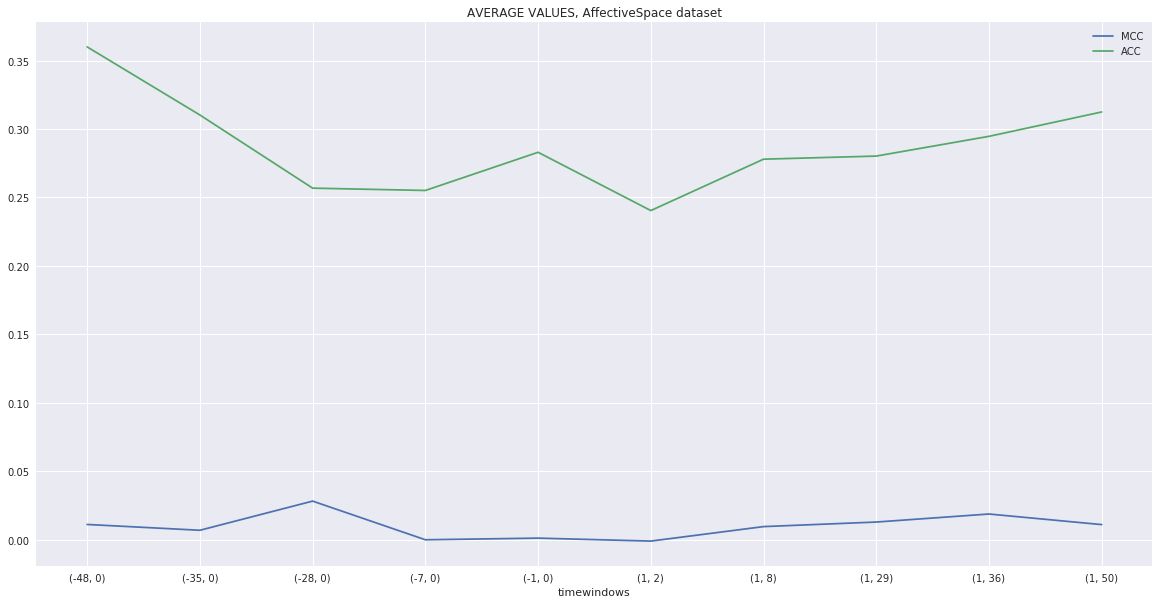

[array([[ 1167., 14831.,  4916.],
       [  704., 10228.,  3532.],
       [ 1202., 14942.,  4745.]]), array([[ 1167., 14831.,  4916.],
       [  704., 10228.,  3532.],
       [ 1202., 14942.,  4745.]]), array([[ 1167., 14831.,  4916.],
       [  704., 10228.,  3532.],
       [ 1202., 14942.,  4745.]]), array([[ 1167., 14831.,  4916.],
       [  704., 10228.,  3532.],
       [ 1202., 14942.,  4745.]]), array([[ 1167., 14831.,  4916.],
       [  704., 10228.,  3532.],
       [ 1202., 14942.,  4745.]]), array([[ 1167., 14831.,  4916.],
       [  704., 10228.,  3532.],
       [ 1202., 14942.,  4745.]]), array([[ 1167., 14831.,  4916.],
       [  704., 10228.,  3532.],
       [ 1202., 14942.,  4745.]]), array([[ 1167., 14831.,  4916.],
       [  704., 10228.,  3532.],
       [ 1202., 14942.,  4745.]]), array([[ 1167., 14831.,  4916.],
       [  704., 10228.,  3532.],
       [ 1202., 14942.,  4745.]]), array([[ 1167., 14831.,  4916.],
       [  704., 10228.,  3532.],
       [ 1202., 14942., 

In [16]:
# PERFORMANCE ON ALL TICKERS
MCCs_avg = [0]*len(TREND_WINDOWs)
ACCs_avg = [0]*len(TREND_WINDOWs)
conf_matr_avg = [np.zeros([3,3])]*len(TREND_WINDOWs)
for ticker in tickers:
    print('\n\n\n==================== '+str(ticker)+' ==================== \n\n\n')
    MCCs = []
    ACCs = []
    ds = DatasetManager()
    ds.load_dataset(ticker = ticker, kind = kind_of_dataset,technicalFeatures=True)

    for (init, finish) in TREND_WINDOWs:
        print('trend: ',init,' ',finish)
        (x_tv,y_tv),(x_test,y_test),_ = ds.get_dataset_for_trend(init, finish)
        (best_c, best_g) = cv(x_tv,y_tv)
        print('Best C: ',best_c,' best gamma: ',best_g)
        svm_model = svm.SVC(kernel='rbf', C=best_c, gamma=best_c)
        svm_model.fit(x_tv,y_tv)
        y_pred = svm_model.predict(x_test)
        mcc = MCC(y_test, y_pred)
        acc = svm_model.score(x_test,y_test)
        confmatrix = confusion_matrix(y_test, y_pred)
        ACCs_avg[TREND_WINDOWs.index((init, finish))]+= acc/len(tickers)
        MCCs_avg[TREND_WINDOWs.index((init, finish))]+= mcc/len(tickers)
        MCCs.append(mcc)
        ACCs.append(acc)
        conf_matr_avg[TREND_WINDOWs.index((init, finish))] += np.asarray(confmatrix)
        print('\ntn, fp, fn, tp: ', confmatrix.ravel())

    plt.figure(figsize=(20,10))
    plt.plot(MCCs, label='MCC')
    plt.plot(ACCs, label='ACC')
    plt.xlabel('timewindows')
    plt.xticks(range(0,len(TREND_WINDOWs)), TREND_WINDOWs)
    plt.title(ticker)
    plt.legend()
    plt.show() 

plt.figure(figsize=(20,10))
plt.plot(MCCs_avg, label='MCC')
plt.plot(ACCs_avg, label='ACC')
plt.xlabel('timewindows')
plt.xticks(range(0,len(TREND_WINDOWs)), TREND_WINDOWs)
plt.title('AVERAGE VALUES, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
print(conf_matr_avg)